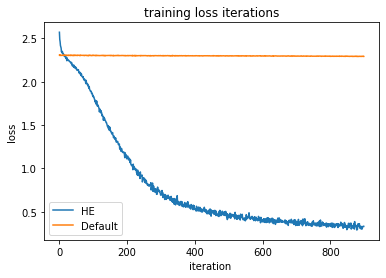

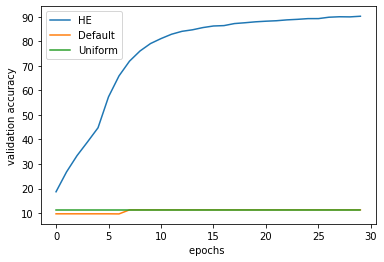

In [10]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

torch.manual_seed(0)

input_dim = 28 * 28
output_dim = 10
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]
epochs =30

class Net_He(nn.Module):
  def __init__(self,layers):
    super(Net_He,self).__init__()
    self.the_list = nn.ModuleList()
    for in_,out_ in zip (layers,layers[1:]):
      linear = nn.Linear(in_,out_)
      nn.init.kaiming_uniform_(linear.weight,nonlinearity='relu')
      self.the_list.append(linear)
    
  def forward(self,x):
    L = len(self.the_list)
    for l, linear in zip(range(L),self.the_list):
      if(l<L-1):
        x = F.relu(linear(x))
      else:
        x = linear(x)
    return x

model_HE = Net_He(layers)

class Net_Uniform(nn.Module):
  def __init__(self,layers):
    super(Net_Uniform,self).__init__()
    self.the_list = nn.ModuleList()
    for in_,out_ in zip (layers,layers[1:]):
      linear = nn.Linear(in_,out_)
      linear.weight.data.uniform_(0,1)
      self.the_list.append(linear)
    
  def forward(self,x):
    L = len(self.the_list)
    for l, linear in zip(range(L),self.the_list):
      if(l<L-1):
        x = F.relu(linear(x))
      else:
        x = linear(x)
    return x

model_Uniform = Net_Uniform(layers)



class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            self.hidden.append(linear)
        
    def forward(self, x):
        L=len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))
            else:
                x = linear_transform(x)
                
        return x


model = Net(layers)


train_data = dsets.MNIST(root="./data",train=True,transform=transforms.ToTensor(),download=True)
valid_data = dsets.MNIST(root="./data",train=False,transform=transforms.ToTensor(),download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=2000,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,batch_size=5000,shuffle=False)


def train(model,optimiser,epochs):
  LOSS = { "train":[],"valid":[]}
  for epoch in range(epochs):
    for x,y in train_loader:
      yhat = model(x.view(-1,input_dim))
      loss = criterion(yhat,y)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      LOSS["train"].append(loss.item())

    correct=0
    for x,y in valid_loader:
      z = model(x.view(-1,input_dim))
      _,yhat = z.max(1)
      correct+=(yhat==y).sum().item()
    acc = 100*(correct/len(valid_data))
    LOSS['valid'].append(acc)
  
  return LOSS

criterion = nn.CrossEntropyLoss()
lr = 0.01


#Default
optimiser = torch.optim.SGD(model.parameters(),lr=lr)
LOSS = train(model,optimiser,epochs)

# HE
optimiser = torch.optim.SGD(model_HE.parameters(),lr=lr)
LOSS_HE = train(model_HE,optimiser,epochs)

# Uniform
optimiser = torch.optim.SGD(model_Uniform.parameters(),lr=lr)
LOSS_Uniform = train(model_Uniform,optimiser,epochs)



# Plot the loss

plt.plot(LOSS_HE['train'], label='HE')
plt.plot(LOSS['train'], label='Default')
#plt.plot(LOSS_Uniform['train'], label='Uniform')
plt.ylabel('loss')
plt.xlabel('iteration ')  
plt.title('training loss iterations')
plt.legend()
plt.show()


# Plot the loss

plt.plot(LOSS_HE['valid'], label='HE')
plt.plot(LOSS['valid'], label='Default')
plt.plot(LOSS_Uniform['valid'], label='Uniform')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')  
plt.legend()
plt.show()
